---
#### <b>Name : Ayodya W.K.H</b>
#### <b>Index No : 190065K</b>
#### <b>Asssignment II - Fitting and Allignment</b>
---
##### GitHub Link : https://github.com/ayodyawkh/EN2550/blob/main/Assignment_2/Assignment_2.ipynb
---

#### <b>Question 1</b>

In [80]:
import numpy as np 
from scipy.optimize import minimize 
from scipy import linalg 
import matplotlib.pyplot as plt
import random


N = 100 
half_n = N//2
r = 10 
s = r/16 
t = np.random.uniform(0, 2*np.pi, half_n) 
n = s*np.random.randn(half_n) 
x1 , y1 = (r + n) * np.cos(t), (r + n) * np.sin(t) 
X_circ = np.hstack((x1.reshape(half_n, 1) , y1.reshape(half_n, 1))) 

m, b = -1, 2 
x2 = np.linspace(-12, 12, half_n) 
y2 = m * x2 + b + s * np.random.randn(half_n) 
X_line = np.hstack((x2.reshape(half_n, 1) , y2.reshape(half_n, 1))) 
X = np.vstack((X_circ , X_line))
y = y1 + y2

In [81]:
class RANSAC:
    def __init__(self, x_data, y_data, min_samples, dis_thres, num_samples):
        self.x_data = x_data
        self.y_data = y_data
        self.s = min_samples
        self.t = dis_thres
        self.N = num_samples
        self.best_model = None
        self.inliers = []
        self.outliers = []
        self.points = []

    def distance(self, p1, p2):
        return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

    def random_sample(self):
        self.points = []
        i = 0
        while i < self.s:
            ind = random.randint(0, len(self.x_data) - 1)
            pnt = (self.x_data[ind], self.y_data[ind])
            if pnt not in self.points:
                self.points.append(pnt)
                i += 1

    def circle_equation(self):
        pt1, pt2, pt3 = self.points
        Y = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]])
        Z = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])
        inverse_Y = linalg.inv(Y)
        c_x, c_y = np.dot(inverse_Y, Z) / 2
        cx, cy = c_x[0], c_y[0]
        r = np.sqrt((cx - pt1[0])**2 + (cy - pt1[1])**2)
        return cx, cy, r

    def inliers_filter(self):
        new_inliers = []
        new_outliers = []
        xc, yc, r=self.circle_equation()
        for i in range(len(self.x_data)):
            dist = self.distance((self.x_data[i], self.y_data[i]), (xc,yc))
            if abs(dist - r) <= self.t:
                new_inliers.append((self.x_data[i], self.y_data[i]))
            else:
                new_outliers.append((self.x_data[i], self.y_data[i]))   
        if len(self.inliers) < len(new_inliers):
            self.inliers = new_inliers
            self.outliers = new_outliers
            self.best_model = (xc,yc,r)

    def model_finder(self):
        for i in range(self.N):
            self.random_sample()
            self.inliers_filter()
        return self.best_model  

In [82]:
best_samp = RANSAC(X[:,0], X[:,1], 3, 1, 35)
best_samp.model_finder()

(235.87326758347146, 230.95859494409427, 329.06494626340395)

In [83]:
ransac = RANSAC(np.array(best_samp.inliers)[:,0], np.array(best_samp.inliers)[:, 1], 3, 1, 35)
ransac.model_finder()

(-143.55497191367374, -140.12263097425955, 202.22314894761124)

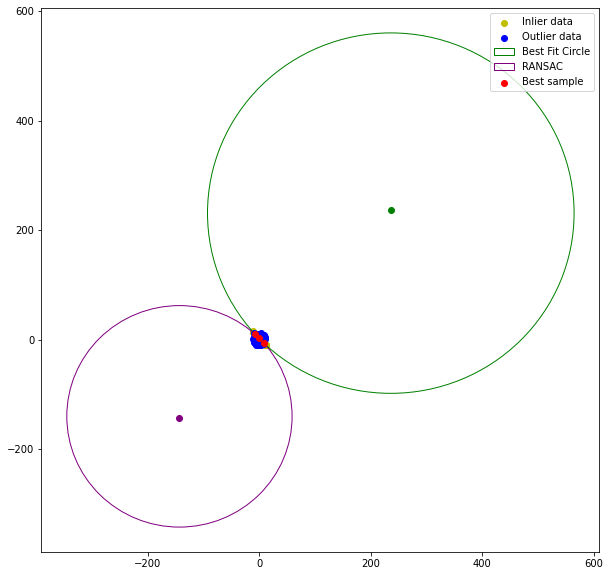

In [84]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(np.array(best_samp.inliers)[:,0], np.array(best_samp.inliers)[:, 1], c = 'y', label = 'Inlier data')
ax.scatter(np.array(best_samp.outliers)[:,0], np.array(best_samp.outliers)[:,1], c = 'b', label = 'Outlier data')

circle1 = plt.Circle((best_samp.best_model[0], best_samp.best_model[1]), best_samp.best_model[2], color = 'green', fill = False, label = 'Best Fit Circle')
ax.add_patch(circle1)
circle2 = plt.Circle((ransac.best_model[0], ransac.best_model[1]), ransac.best_model[2], color = 'purple', fill = False,label = 'RANSAC')
ax.add_patch(circle2)

ax.scatter(np.array(best_samp.points)[:, 0], np.array(best_samp.points)[:, 1], c = 'r', label = 'Best sample')
ax.scatter(best_samp.best_model[0], best_samp.best_model[0], c = 'green')
ax.scatter(ransac.best_model[0], ransac.best_model[0], c = 'purple')
ax.legend(loc = 'upper right')
plt.show()

The best fit circle is the circle which has the most number of inliers. The RANSAC circle is the circle which is fitting best to those inliers. The most accurate circle for those noisy places is the RANSAC circle.

#### <b>Question 2</b>

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

img_hall = cv.imread(r'hall.jpg')
assert img_hall is not None
img_flag = cv.imread(r'flag.png')
assert img_flag is not None

hall_height, hall_width = np.shape(img_hall)[0], np.shape(img_hall)[1]
flag_height, flag_width = np.shape(img_flag)[0], np.shape(img_flag)[1]

#code to get the mouse click points
click_pts = []
def click_left_button(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONDOWN:
        click_pts.append([x,y])

cv.imshow('image', img_hall)
cv.setMouseCallback('image', click_left_button)
cv.waitKey(0)
cv.destroyAllWindows()

#points corresponding to the mouse clicks
x_1 = click_pts[0][0]
y_1 = click_pts[0][1]

x_2 = click_pts[1][0]
y_2 = click_pts[1][1]

x_3 = click_pts[2][0]
y_3 = click_pts[2][1]

x_4 = click_pts[3][0]
y_4 = click_pts[3][1]

#get corner points of the flag
x_1T = np.array([[0, 0, 1]])
x_2T = np.array([[flag_width - 1, 0, 1]])
x_3T = np.array([[flag_width - 1, flag_height - 1, 1]])
x_4T = np.array([[0, flag_height - 1, 1]])

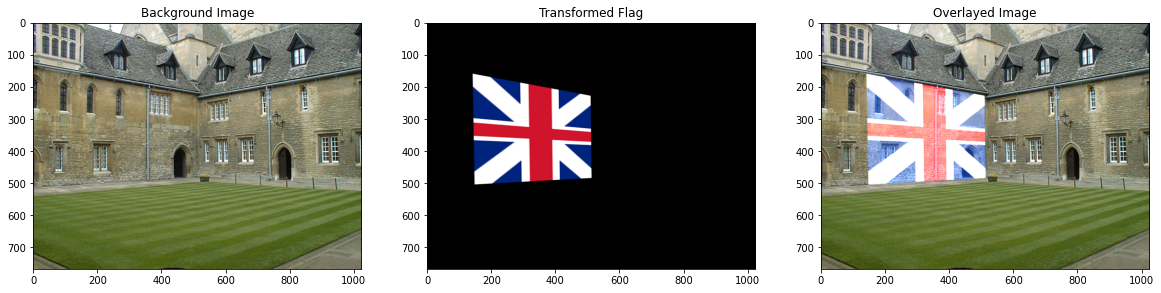

In [20]:
#make the matrix A
zero_matrix = np.array([[0],[0],[0]])

a = np.concatenate((zero_matrix.T, x_1T, -y_1 * x_1T), axis = 1)
b = np.concatenate((x_1T, zero_matrix.T, -x_1 * x_1T), axis = 1)

c = np.concatenate((zero_matrix.T, x_2T, -y_2 * x_2T), axis = 1)
d = np.concatenate((x_2T, zero_matrix.T, -x_2 * x_2T), axis = 1)

e = np.concatenate((zero_matrix.T, x_3T, -y_3 * x_3T), axis = 1)
f = np.concatenate((x_3T, zero_matrix.T, -x_3 * x_3T), axis = 1)

g = np.concatenate((zero_matrix.T, x_4T, -y_4 * x_4T), axis = 1)
h = np.concatenate((x_4T, zero_matrix.T, -x_4 * x_4T), axis = 1)

A = np.concatenate((a,b,c,d,e,f,g,h), axis = 0, dtype = np.float64)

Final_Matrix = (A.T)@A
W,V = np.linalg.eig(Final_Matrix)
temph = V[:, np.argmin(W)]
H = temph.reshape((3,3))

flag_transformed = cv.warpPerspective(img_flag, H,(hall_width, hall_height))
output = cv.add(flag_transformed,img_hall)

fig, ax = plt.subplots(1,3,figsize=(20,20))
ax[0].imshow(cv.cvtColor(img_hall, cv.COLOR_BGR2RGB)), ax[0].set_title("Background Image")
ax[1].imshow(cv.cvtColor(flag_transformed, cv.COLOR_BGR2RGB)), ax[1].set_title("Transformed Flag")
ax[2].imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB)), ax[2].set_title("Overlayed Image")
plt.show()

#### <b>Question 3</b>

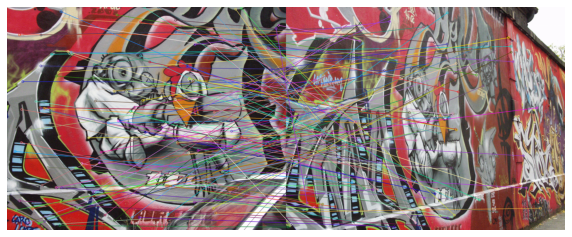

In [55]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

img1=cv.imread(r'img1.ppm')
img5=cv.imread(r'img5.ppm')
gray_1 = cv.cvtColor(img_1, cv.COLOR_BGR2GRAY)
gray_5 = cv.cvtColor(img_5, cv.COLOR_BGR2GRAY)

sift = cv.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(gray_1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(gray_5, None)

bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des5, k=2)

good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append([m])

img_new = cv.drawMatchesKnn(img1, keypoints_1, img5, keypoints_2, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig,ax=plt.subplots(1, 1, figsize = (10,10))
ax.imshow(cv.cvtColor(img_new, cv.COLOR_BGR2RGB)), ax.axis('off')
plt.show()

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

def siftMatchPoints(img1,img2):
    sift = cv.xfeatures2d.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors_1, descriptors_2, k = 2)
    pts1 = []
    pts2 = []

    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            pts2.append(keypoints_2[m.trainIdx].pt)
            pts1.append(keypoints_1[m.queryIdx].pt)
            
    src_pts = np.concatenate((np.int32(pts1), np.ones((np.int32(pts1).shape[0], 1))), axis = 1)
    dst_pts = np.concatenate((np.int32(pts2), np.ones((np.int32(pts2).shape[0], 1))), axis = 1)
    return src_pts,dst_pts

In [59]:
def ransacHomography(src_pts, dst_pts):
    maxI = 0
    maxLSrc = []
    maxLDest = []
    for i in range(500):
        randInt1, randInt2, randInt3, randInt4 = np.random.randint(0,2000,4)%(src_pts.shape[0])
        while randInt1==randInt2 or randInt2==randInt3 or randInt3==randInt1 or randInt4==randInt1 or randInt3==randInt4 or randInt2==randInt4:
            randInt1, randInt2, randInt3, randInt4 = np.random.randint(0,2000,4)%(src_pts.shape[0])
            
        src_pts1 = np.array([src_pts[randInt1], src_pts[randInt2], src_pts[randInt3], src_pts[randInt4]])
        dst_pts1 = np.array([dst_pts[randInt1],dst_pts[randInt2],dst_pts[randInt3],dst_pts[randInt4]])
        
        A = []
        for i in range(src_pts1.shape[0]):
            x, y, z = src_pts1[i][0], src_pts1[i][1], src_pts1[i][2]
            xp, yp = dst_pts1[i][0], dst_pts1[i][1]
            A.append([x, y, z, 0, 0, 0, -xp * x, -xp * y, -xp * z])
            A.append([0, 0, 0, x, y, z, -yp * x, -yp * y, -yp * z])
        A = np.array(A) 
        w,v = np.linalg.eig(A.T @ A)
        H = v[:, np.argmin(w)]
        H = H.reshape((3,3))
        H = H/H[-1,-1]
        
        epsilon = 25
        inlines = 0
        linesSrc = []
        lineDest = []
        for k in range(src_pts.shape[0]):
            x_ = H@src_pts[k,:].reshape(3, 1)
            x_ = x_ [:2].reshape(1, 2)[0]
            x__ = (dst_pts[k, 0:2].reshape(1, 2)[0] - x_)

            if  abs(x__[0])< epsilon and abs(x__[1]) < epsilon:
                inlines += 1
                linesSrc.append(src_pts[k,:])
                lineDest.append(dst_pts[k,:])
                
        if inlines > maxI:
            maxI = inlines
            maxLSrc = linesSrc.copy()
            maxLSrc = np.asarray(maxLSrc, dtype=np.float32)
            maxLDest = lineDest.copy()
            maxLDest = np.asarray(maxLDest, dtype=np.float32)
    return maxLSrc, maxLDest

def findH(src_pts, dst_pts):
    src_pts, dst_pts = ransacHomography(src_pts, dst_pts)
    A = []
    for i in range(src_pts.shape[0]):
        x, y, z = src_pts[i][0], src_pts[i][1], src_pts[i][2]
        xp, yp = dst_pts[i][0], dst_pts[i][1]
        A.append([x, y, z, 0, 0, 0, -x * xp, -xp * y, -xp * z])
        A.append([0, 0, 0, x, y, z, -yp * x, -yp * y, -yp * z])
    A = np.array(A) 
    w,v = np.linalg.eig(A.T @ A)
    H = v[:, np.argmin(w)]
    H = H.reshape((3,3))
    H = H/H[-1,-1]
    return H

In [74]:
img1=cv.imread(r'img1.ppm')
img2=cv.imread(r'img2.ppm')
img3=cv.imread(r'img3.ppm')
img4=cv.imread(r'img4.ppm')
img5=cv.imread(r'img5.ppm')

src_pts1,dst_pts1 = siftMatchPoints(img1,img2)
pts1,pts2 = ransacHomography(src_pts1,dst_pts1)
H1 = findH(pts1,pts2)
src_pts2,dst_pts2 = siftMatchPoints(img2,img3)
pts3,pts4 = ransacHomography(src_pts2,dst_pts2)
H2 = findH(pts3,pts4)
src_pts3,dst_pts3 = siftMatchPoints(img3,img4)
pts5,pts6 = ransacHomography(src_pts3,dst_pts3)
H3 = findH(pts5,pts6)
src_pts4,dst_pts4 = siftMatchPoints(img4,img5)
pts7,pts8 = ransacHomography(src_pts4,dst_pts4)
H4 = findH(pts7,pts8)
H = H4@H3@H2@H1

In [75]:
H_given=[]
with open(r'H1to5p') as f:
    H_given=np.array([[float(h) for h in line.split()] for line in f])

print('H - calculated\n', H,'\n')
print('H - given\n', H_given,'\n')

print('SSD between calculated H and given homography matrix: ',sum(sum((np.square(H - H_given)))))

H - calculated
 [[ 6.15158940e-01  5.46048170e-02  2.20477373e+02]
 [ 2.18524434e-01  1.13513135e+00 -2.16724646e+01]
 [ 4.85795148e-04 -6.32875320e-05  9.92592833e-01]] 

H - given
 [[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]] 

SSD between calculated H and given homography matrix:  17.826333193591143


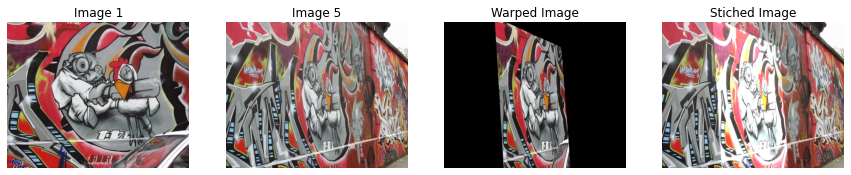

In [79]:
im1to5 = cv.warpPerspective(img1,H,(img5.shape[1],img5.shape[0]))
stiched_img = cv.add(img5,im1to5)

fig,ax=plt.subplots(1,4,figsize=(15,15))
ax[0].imshow(cv.cvtColor(img1,cv.COLOR_BGR2RGB)), ax[0].axis('off'), ax[0].set_title("Image 1")
ax[1].imshow(cv.cvtColor(img5,cv.COLOR_BGR2RGB)), ax[1].axis('off'), ax[1].set_title("Image 5")
ax[2].imshow(cv.cvtColor(im1to5,cv.COLOR_BGR2RGB)), ax[2].axis('off'), ax[2].set_title("Warped Image")
ax[3].imshow(cv.cvtColor(stiched_img,cv.COLOR_BGR2RGB)), ax[3].axis('off'), ax[3].set_title("Stiched Image")
plt.show()

##### Homography matrix of 1 to 5 is calculated by multiplying 1 to 2, 2 to 3, 3 to 4, 4 to 5 homography metrices.
    img2 = H1@img1 
    img3 = H2@(H1@img1)
    img4 = H3@(H2@(H1@img1))
    img5 = H4@(H3@(H2@(H1@img1))) = H4@H3@H2@H1@img1
Inorder to eliminate the fake points given by the SIFT matching, The RANSAC algorithm is used. 